In [20]:
import os
import subprocess
import sys

import matplotlib.pyplot as plt
import torch

CUDA = "1"

In [ ]:
for num_sessions in (5,):
    for num_bases in range(10, 60, 10):
        for coadapt in [True, False]:
            # Log the start of the run
            log_msg = f"Starting run: coadapt={coadapt}, num_bases={num_bases}, num_sessions={num_sessions}\n"
            with open("training_log.txt", "a") as log_file:
                log_file.write(log_msg)
            print(log_msg.strip())
            
            # Run the generation script
            cmd = [
                "python", "tma_standalone.py",
                str(num_bases),
                str(num_sessions),
                CUDA,
                str(coadapt),
            ]
            
            try:
                print(f"Launching subprocess for {num_bases}_{num_sessions}_{'coadapt' if coadapt else 'inner'}")
                # Set environment to unbuffer Python output
                env = os.environ.copy()
                env['PYTHONUNBUFFERED'] = '1'
                process = subprocess.Popen(
                    cmd,
                    stdout=subprocess.PIPE,
                    stderr=subprocess.STDOUT,
                    text=True,
                    bufsize=1,
                    env=env
                )
                print(f"Subprocess launched, PID: {process.pid}")
                
                # Check if it exits quickly
                import time
                time.sleep(2)  # Wait 2 seconds
                if process.poll() is not None:
                    print(f"Process exited early with code: {process.returncode}")
                    # Read any remaining output
                    remaining = process.stdout.read()
                    if remaining:
                        print("Early output:", remaining)
                    else:
                        print("No output before exit")
                    # Skip the loop and go to wait
                else:
                    print("Process is running, starting output stream...")
                
                # Stream output line by line
                output_lines = 0
                with open("training_log.txt", "a") as log_file:
                    for line in process.stdout:
                        print(line, end='')       # print without adding extra newline
                        sys.stdout.flush()        # ensure it shows immediately in Jupyter
                        log_file.write(line)      # Save to log
                        log_file.flush()          # Ensure it's written immediately
                        output_lines += 1
                        if output_lines % 100 == 0:  # Print progress every 100 lines
                            print(f"[Progress: {output_lines} lines output]")
                
                process.wait()
                print(f"Subprocess finished with return code: {process.returncode}")
                
                # Log the completion
                if process.returncode == 0:
                    success_msg = f"Completed successfully: coadapt={coadapt}, num_bases={num_bases}, num_sessions={num_sessions}\n"
                    with open("training_log.txt", "a") as log_file:
                        log_file.write(success_msg)
                    print(success_msg.strip())
                else:
                    error_msg = f"Failed with return code {process.returncode}: coadapt={coadapt}, num_bases={num_bases}, num_sessions={num_sessions}\n"
                    with open("training_log.txt", "a") as log_file:
                        log_file.write(error_msg)
                    print(error_msg.strip())
                    
            except Exception as e:
                exception_msg = f"Exception occurred: {e} for coadapt={coadapt}, num_bases={num_bases}, num_sessions={num_sessions}\n"
                with open("training_log.txt", "a") as log_file:
                    log_file.write(exception_msg)
                print(exception_msg.strip())

Starting run: coadapt=True, num_bases=10, num_sessions=5
Launching subprocess for 10_5_coadapt
Subprocess launched, PID: 1473502
Process is running, starting output stream...
Process is running, starting output stream...
----------- 10 5 1 --
----------- 10 5 1 --
Batch shapes:
Train
torch.Size([5000, 20, 93])
Test
torch.Size([2500, 20, 93])
Building and fitting normalizers...
Batch shapes:
Train
torch.Size([5000, 20, 93])
Test
torch.Size([2500, 20, 93])
Building and fitting normalizers...
Building and warm starting AEs...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
Building TBFM...
BOOM! Dino DNA!
---- 0 0.54953533411026 0.5472051501274109 0.11506234258413314 0.3672892451286316
---- 0 0.54953533411026 0.5472051501274109 0.11506234258413314 0.3672892451286316
---- 1000 0.3159354031085968 0.3808097541332245 0.49309219121932985 0.5736618041992188
---- 1000 0.3159354031085968 0.3808097541332245 0.49309219121932985 0.5736618041992188
---- 2000 0.3002016842365265 0.36

In [21]:
# Summarize results
subdirs = os.listdir("test")

tr2s = {}
snum_bases = set()
snum_sessions = set()
coadapt_types = set()
for sd in subdirs:
    rpath = os.path.join("test", sd, "r_nf_1.torch")
    res = torch.load(rpath, map_location="cpu")

    try:
        parts = sd.split("_")
        if len(parts) == 3:
            num_bases, num_sessions, coadapt_type = parts
            num_bases = int(num_bases)
            num_sessions = int(num_sessions)
        else:
            continue
    except ValueError:
        continue

    snum_bases.add(num_bases)
    snum_sessions.add(num_sessions)
    coadapt_types.add(coadapt_type)

    _tr2s = res["final_test_r2s"]
    for sid, tr2 in _tr2s.items():
        sres = (tr2, num_bases, num_sessions, coadapt_type)
        v = tr2s.setdefault(sid, [])
        v.append(sres)

for _t in tr2s.values():
    _t.sort()

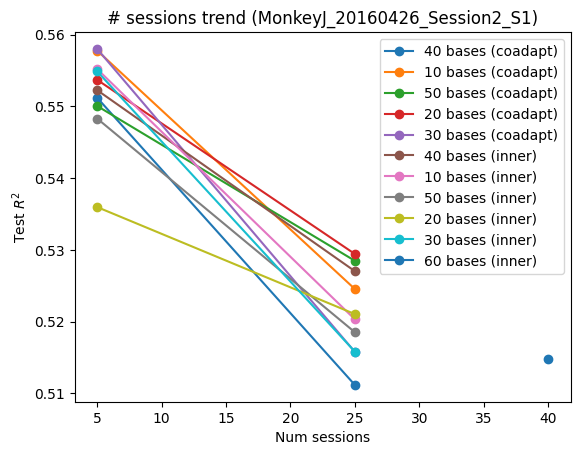

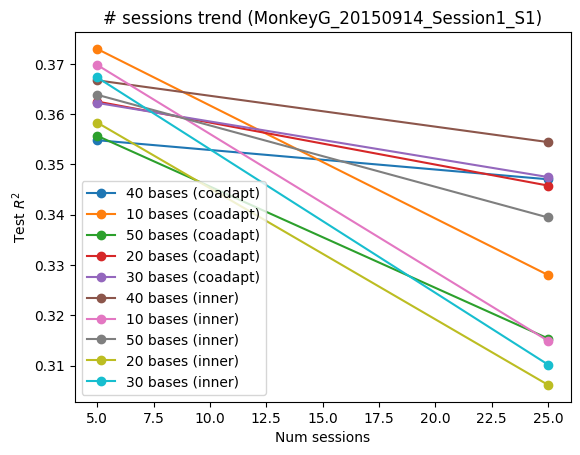

In [22]:
def graph_num_sessions(sid, extras=[]):
    # Separate trends by coadapt type
    trends_by_type = {}
    for coadapt_type in coadapt_types:
        trends_by_type[coadapt_type] = {n: [] for n in snum_bases}
    
    for _tr2 in tr2s[sid]:
        tr2, num_bases, num_sessions, coadapt_type = _tr2
        if coadapt_type in trends_by_type:
            trends_by_type[coadapt_type][num_bases].append((num_sessions, tr2))
        
    for extra in extras:
        ebases, esessions, tr2 = extra
        # Assume extras are for inner loop (default)
        if 'inner' not in trends_by_type:
            trends_by_type['inner'] = {}
        if ebases not in trends_by_type['inner']:
            trends_by_type['inner'][ebases] = []
        trends_by_type['inner'][ebases].append((esessions, tr2))
        
    for coadapt_type, num_sessions_trends in trends_by_type.items():
        for v in num_sessions_trends.values():
            v.sort()

        for num_bases, v in num_sessions_trends.items():
            try:
                x, y = zip(*v)
            except ValueError:
                continue

            plt.plot(x, y, "o-", label=f"{num_bases} bases ({coadapt_type})")
    
    plt.legend()
    plt.title(f"# sessions trend ({sid})")
    plt.xlabel("Num sessions")
    plt.ylabel("Test $R^2$")
    plt.show()

# From all_session model run:
extras = [(60, 40, 0.514821745455265)]
graph_num_sessions("MonkeyJ_20160426_Session2_S1", extras=extras)
graph_num_sessions("MonkeyG_20150914_Session1_S1")

# Saved model model_as_1.torch
all_sessions_top_tr2 = 0.3817160129547119
tr2_60_25_rr0 = 0.4373730155825615

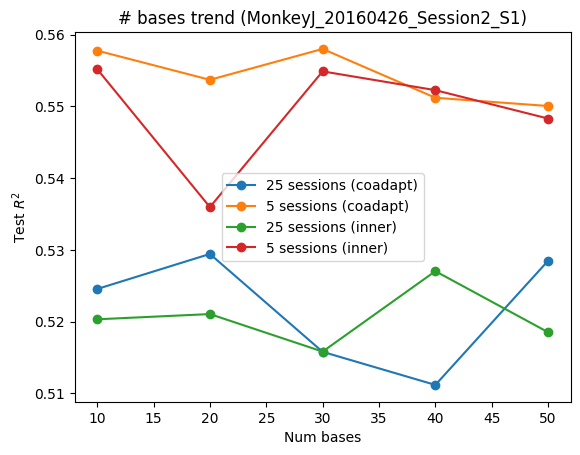

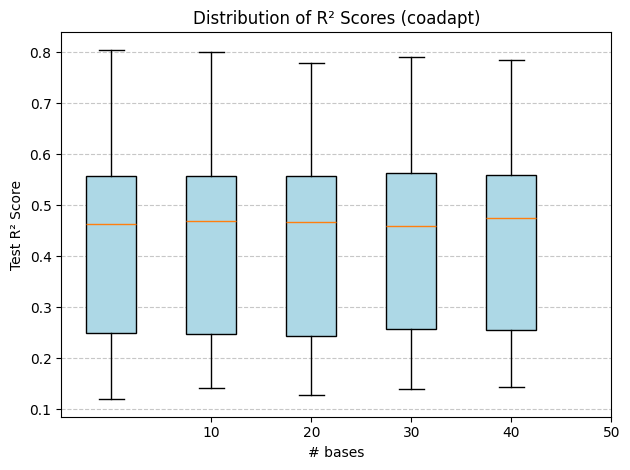

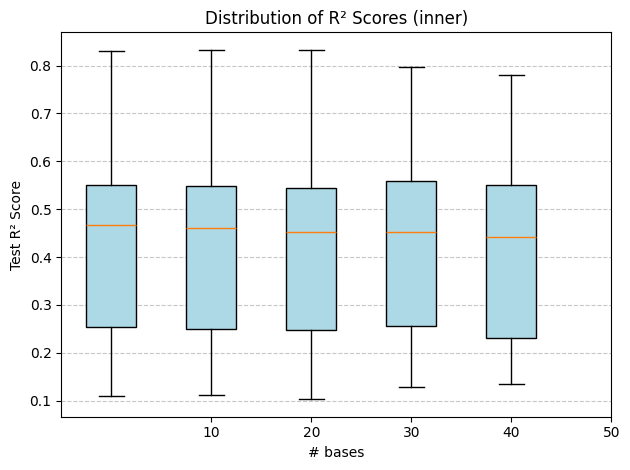

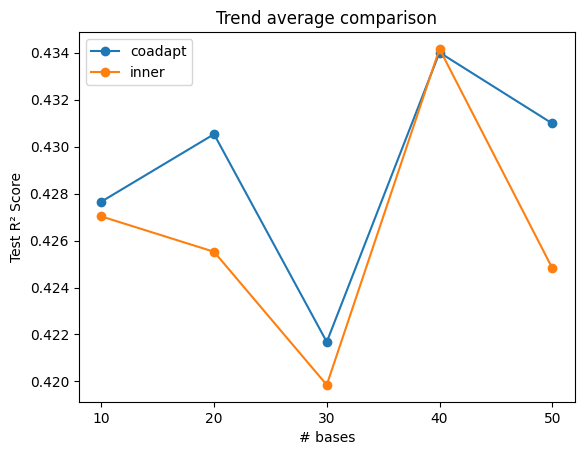

In [ ]:
# Let's trend basis count now. Seems like mixed results...
def graph_num_bases(sid):
    # Separate trends by coadapt type
    trends_by_type = {}
    for coadapt_type in coadapt_types:
        trends_by_type[coadapt_type] = {n: [] for n in snum_sessions}
    
    for _tr2 in tr2s[sid]:
        tr2, num_bases, num_sessions, coadapt_type = _tr2
        if coadapt_type in trends_by_type:
            trends_by_type[coadapt_type][num_sessions].append((num_bases, tr2))
    
    for coadapt_type, num_bases_trends in trends_by_type.items():
        for v in num_bases_trends.values():
            v.sort()
        
        for num_sessions, v in num_bases_trends.items():
            try:
                x, y = zip(*v)
            except ValueError:
                continue
            plt.plot(x, y, "o-", label=f"{num_sessions} sessions ({coadapt_type})")
    
    plt.legend()
    plt.title(f"# bases trend ({sid})")
    plt.xlabel("Num bases")
    plt.ylabel("Test $R^2$")
    plt.show()

    # Boxplot comparison for target_num_sessions
    target_num_sessions = 5   # Let's see the trend averaged for all sessions

    avgs = {}
    for coadapt_type in coadapt_types:
        num_bases_trend = {}   # {num_bases: tr2_list}
        for sid, trends in tr2s.items():
            for v in trends:
                tr2, num_bases, num_sessions, ctype = v
                if num_sessions != target_num_sessions or ctype != coadapt_type:
                    continue
                l = num_bases_trend.setdefault(num_bases, [])
                l.append(tr2)

        a = [(num_bases, l) for num_bases, l in num_bases_trend.items()]
        a.sort()
        
        num_bases, r2_scores = zip(*a)

        plt.boxplot(r2_scores, patch_artist=True, boxprops=dict(facecolor='lightblue'), positions=range(len(num_bases)))
        
        plt.xticks(range(1, len(num_bases) + 1), num_bases)
        plt.xlabel('# bases')
        plt.ylabel('Test R² Score')
        plt.title(f'Distribution of R² Scores ({coadapt_type})')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        avg = []
        for idx, num in enumerate(num_bases):
            r2 = sum(r2_scores[idx])/len(r2_scores[idx])
            avg.append(r2)

        avgs[(coadapt_type, num_bases)] = avg

    for (coadapt_type, num_bases) in avgs:
        plt.plot(num_bases, avgs[(coadapt_type, num_bases)], 'o-', label=f'{coadapt_type}')
    plt.legend()
    plt.xlabel('# bases')
    plt.xticks(num_bases)
    plt.ylabel('Test R² Score')
    plt.title('Trend average comparison')
    plt.show()

graph_num_bases("MonkeyJ_20160426_Session2_S1")

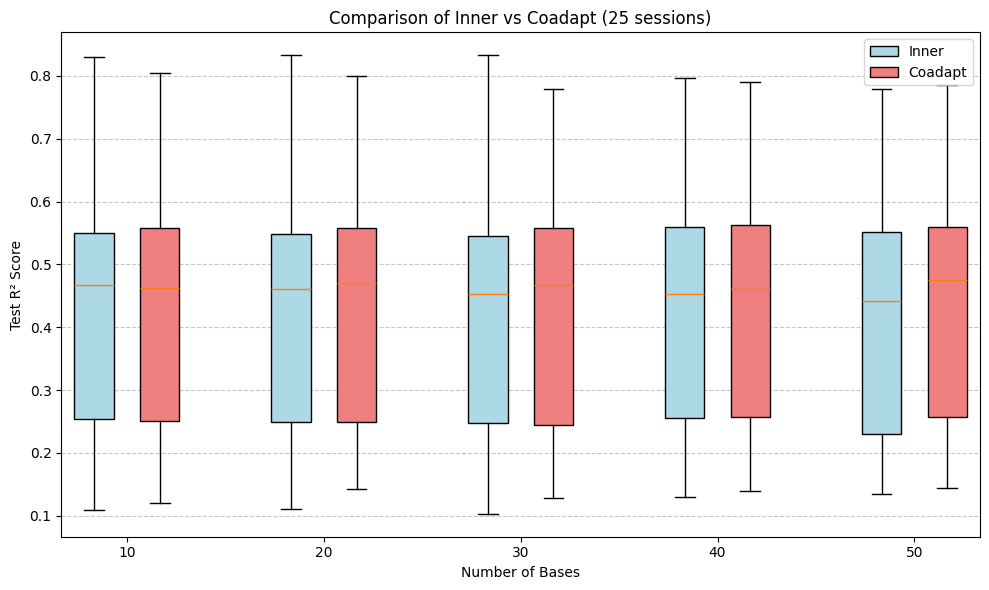

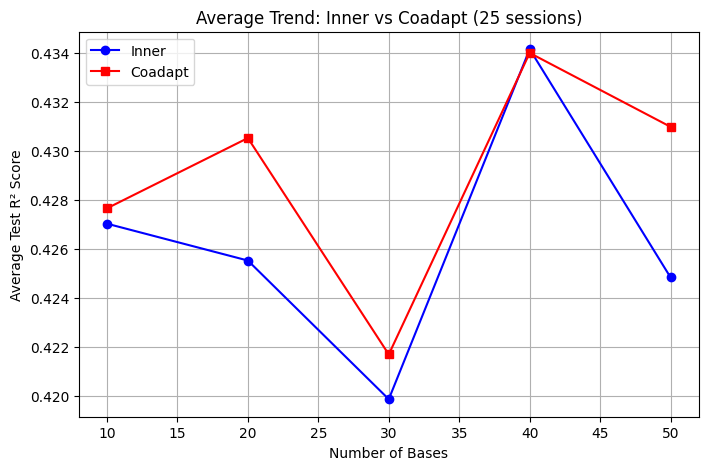

In [24]:
# Comparative plot: inner vs coadapt
import numpy as np

# Collect data for comparison
comparison_data = {}
for sid in tr2s.keys():
    for tr2, num_bases, num_sessions, coadapt_type in tr2s[sid]:
        if num_sessions == 25:  # Focus on 25 sessions as in the loop
            key = (num_bases, coadapt_type)
            if key not in comparison_data:
                comparison_data[key] = []
            comparison_data[key].append(tr2)

# Prepare data for plotting
bases = sorted(set(k[0] for k in comparison_data.keys()))
inner_scores = [comparison_data.get((b, 'inner'), []) for b in bases]
coadapt_scores = [comparison_data.get((b, 'coadapt'), []) for b in bases]

# Boxplot comparison
fig, ax = plt.subplots(figsize=(10, 6))
positions_inner = np.arange(len(bases)) * 3
positions_coadapt = positions_inner + 1

bp_inner = ax.boxplot(inner_scores, positions=positions_inner, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'), label='Inner')
bp_coadapt = ax.boxplot(coadapt_scores, positions=positions_coadapt, widths=0.6, patch_artist=True,
                        boxprops=dict(facecolor='lightcoral'), label='Coadapt')

ax.set_xticks(positions_inner + 0.5)
ax.set_xticklabels(bases)
ax.set_xlabel('Number of Bases')
ax.set_ylabel('Test R² Score')
ax.set_title('Comparison of Inner vs Coadapt (25 sessions)')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Average trend comparison
inner_avgs = [np.mean(scores) if scores else 0 for scores in inner_scores]
coadapt_avgs = [np.mean(scores) if scores else 0 for scores in coadapt_scores]

plt.figure(figsize=(8, 5))
plt.plot(bases, inner_avgs, 'o-', label='Inner', color='blue')
plt.plot(bases, coadapt_avgs, 's-', label='Coadapt', color='red')
plt.xlabel('Number of Bases')
plt.ylabel('Average Test R² Score')
plt.title('Average Trend: Inner vs Coadapt (25 sessions)')
plt.legend()
plt.grid(True)
plt.show()